In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 14.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from collections import defaultdict
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

In [4]:
# Load metadata
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata = pd.read_csv(metadata_path)
metadata.head()

id       genus   species subspecies           name  \
0  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
1  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
2  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
3  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
4  557838  Thryomanes  bewickii        NaN  Bewick's Wren   

                recordist        country  \
0  Whitney Neufeld-Kaiser  United States   
1  Whitney Neufeld-Kaiser  United States   
2  Whitney Neufeld-Kaiser  United States   
3  Whitney Neufeld-Kaiser  United States   
4  Whitney Neufeld-Kaiser  United States   

                                  location  latitude  longitude altitude  \
0  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
1  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
2  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
3  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
4  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   

                   sound_type                   source_url  \
0  adult, sex uncertain, song  //www.xeno-canto.org/557838   
1  adult, sex uncertain, song  //www.xeno-canto.org/557838   
2  adult, sex uncertain, song  //www.xeno-canto.org/557838   
3  adult, sex uncertain, song  //www.xeno-canto.org/557838   
4  adult, sex uncertain, song  //www.xeno-canto.org/557838   

                                        license   time        date  \
0  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
1  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
2  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
3  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   
4  //creativecommons.org/licenses/by-nc-sa/4.0/  11:51  2020-03-14   

                                             remarks      filename  
0  Recorded with Voice Record Pro on iPhone7, nor...  557838-0.wav  
1  Recorded with Voice Record Pro on iPhone7, nor...  557838-1.wav  
2  Recorded with Voice Record Pro on iPhone7, nor...  557838-4.wav  
3  Recorded with Voice Record Pro on iPhone7, nor...  557838-5.wav  
4  Recorded with Voice Record Pro on iPhone7, nor...  557838-6.wav

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


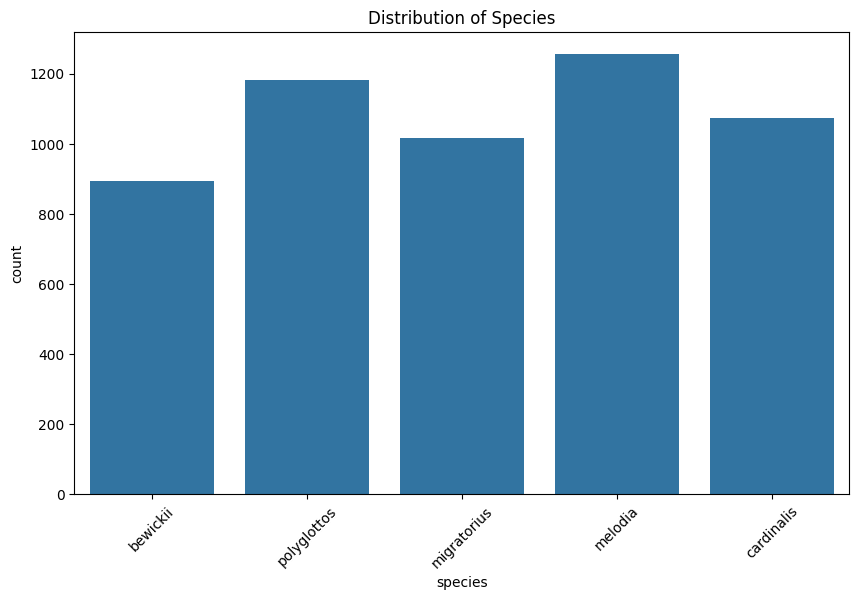

In [6]:
# Plot distributions of a categorical metadata field, e.g., species
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='species')
plt.title('Distribution of Species')
plt.xticks(rotation=45)
plt.show()

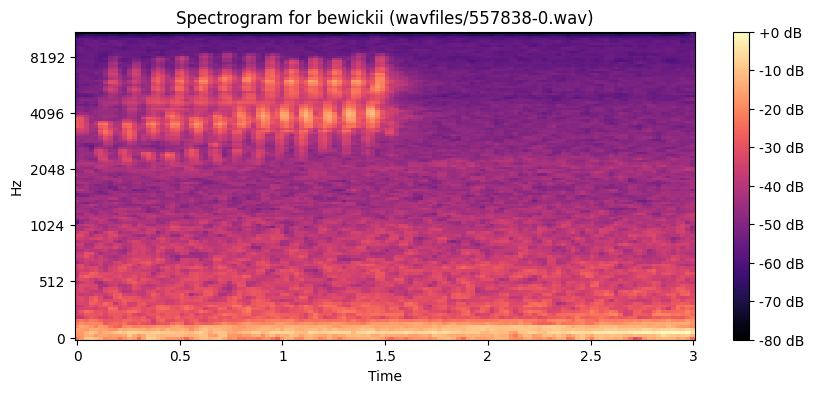

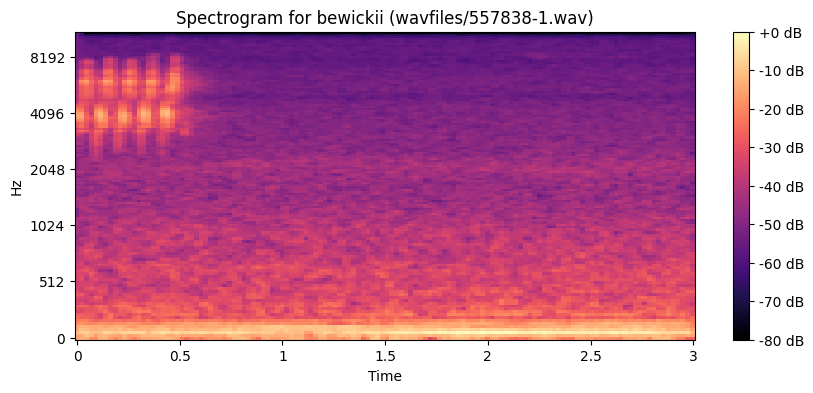

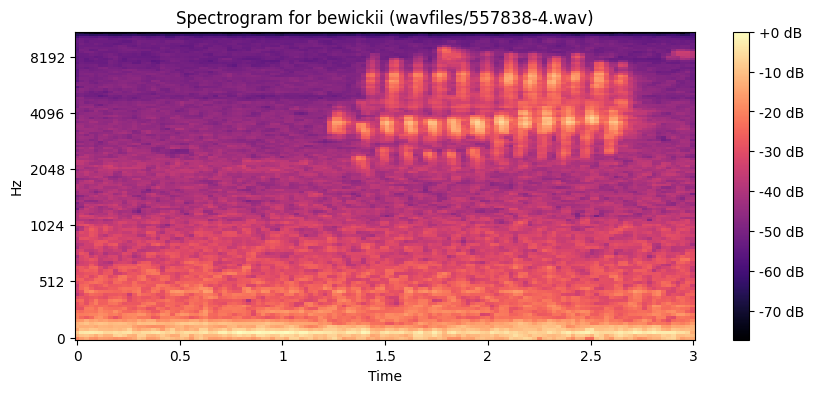

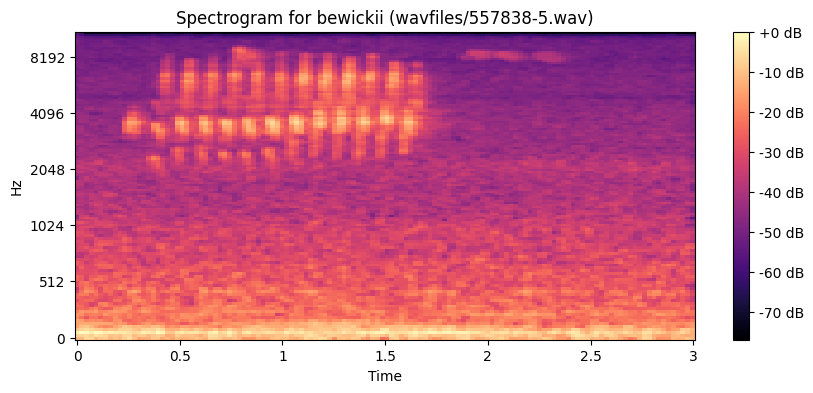

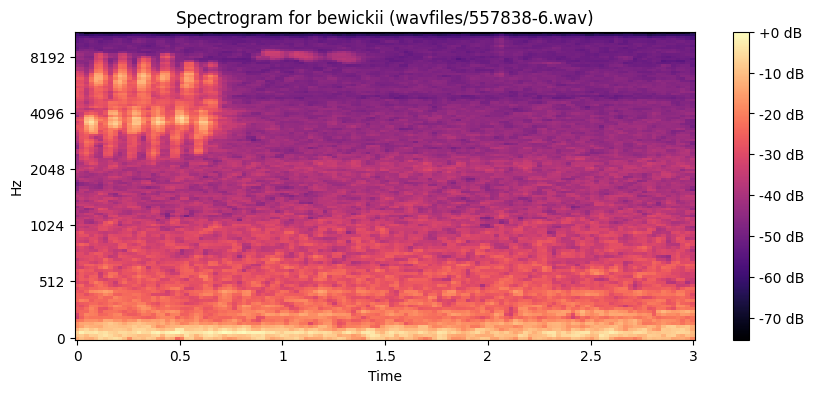

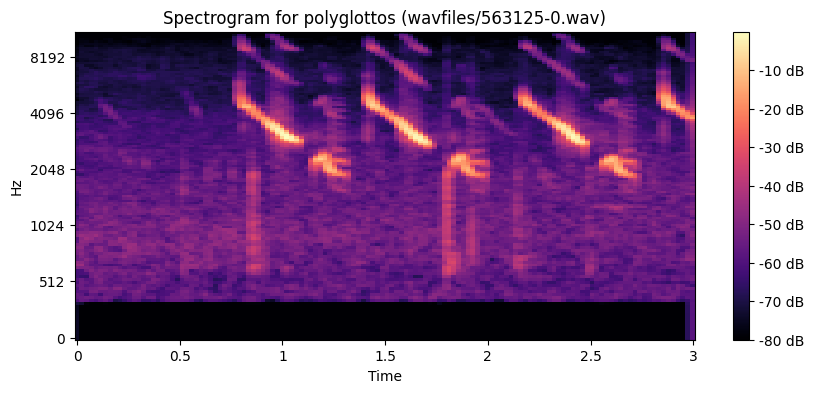

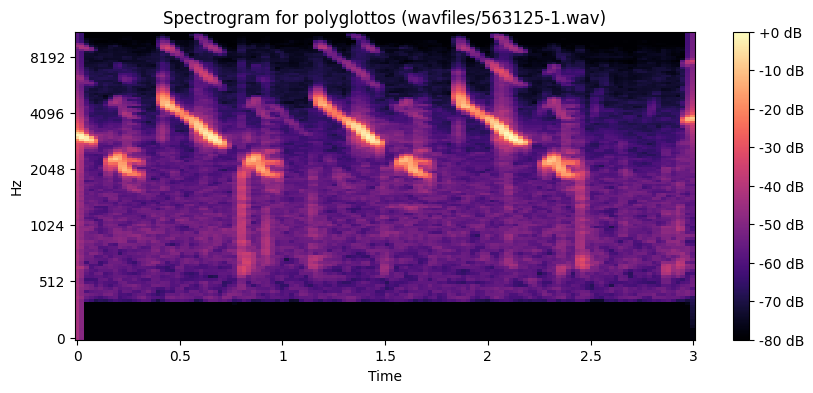

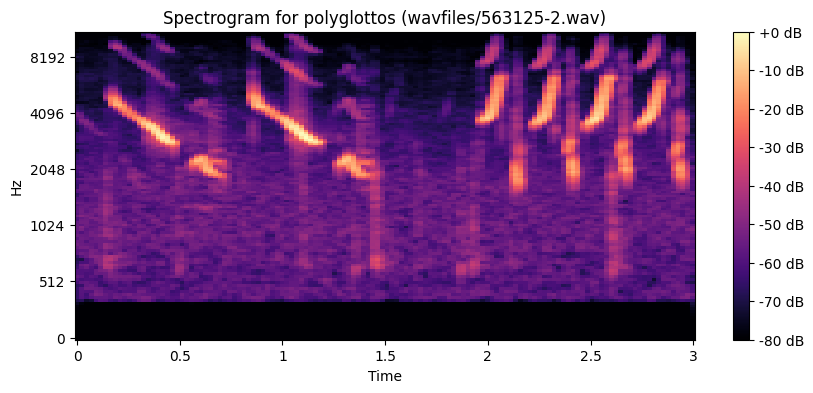

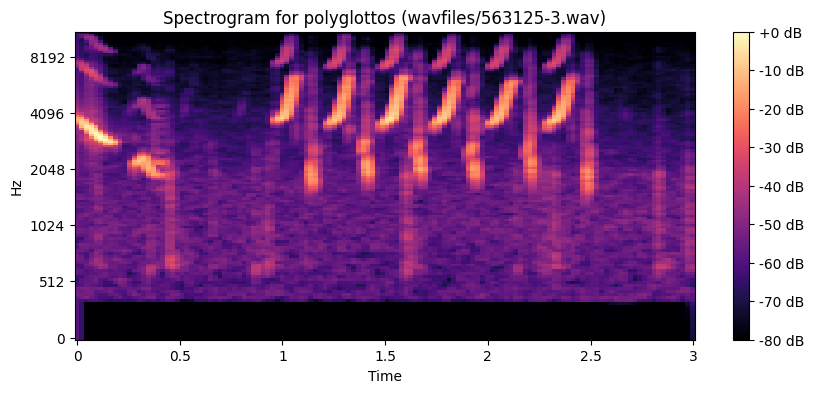

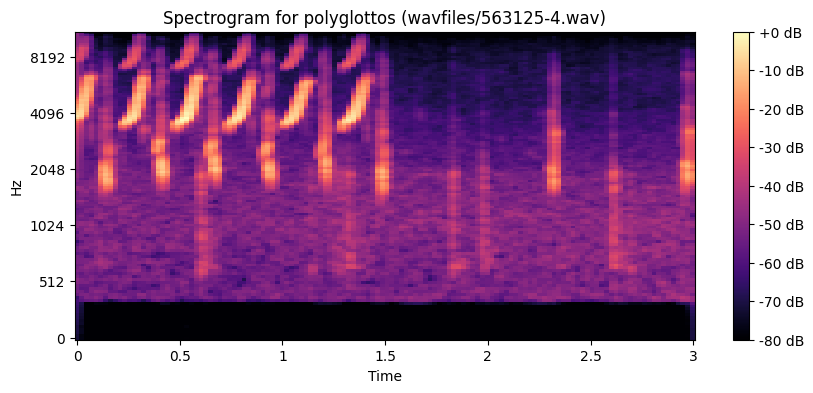

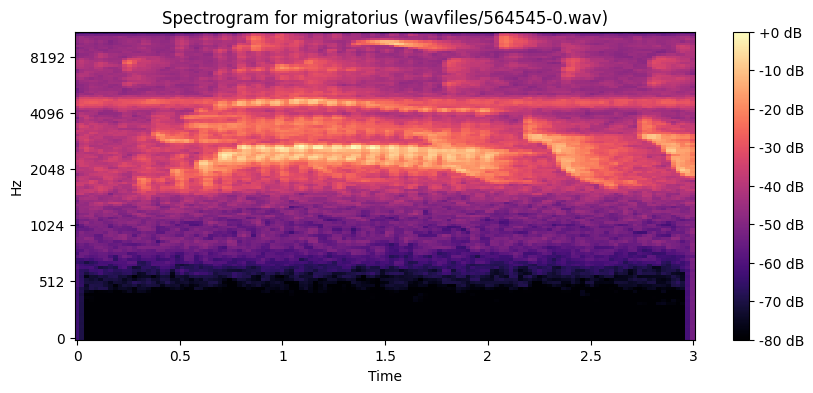

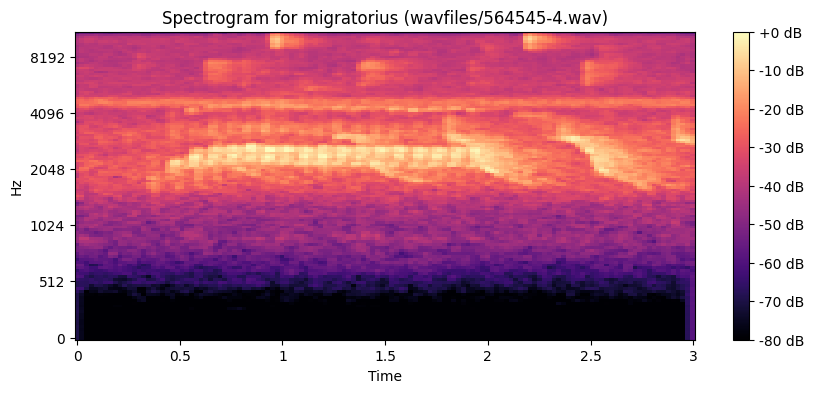

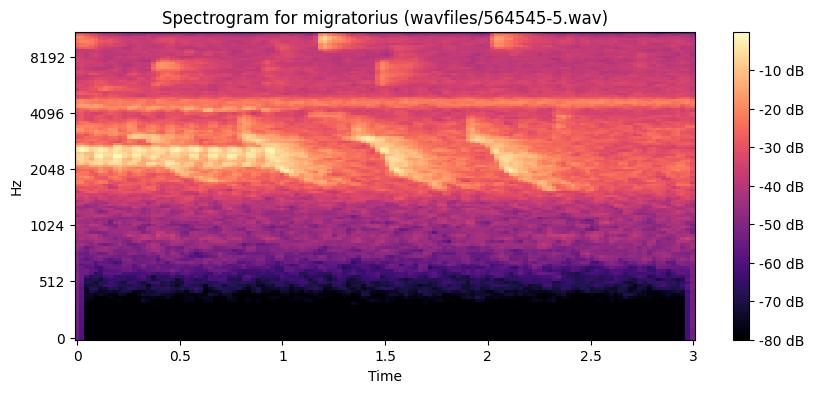

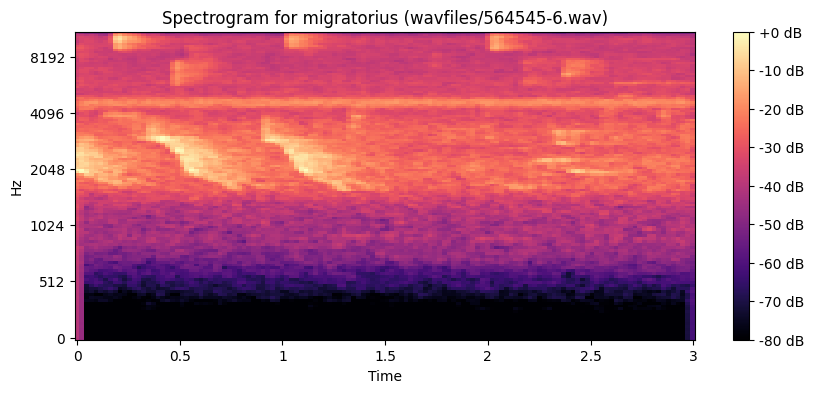

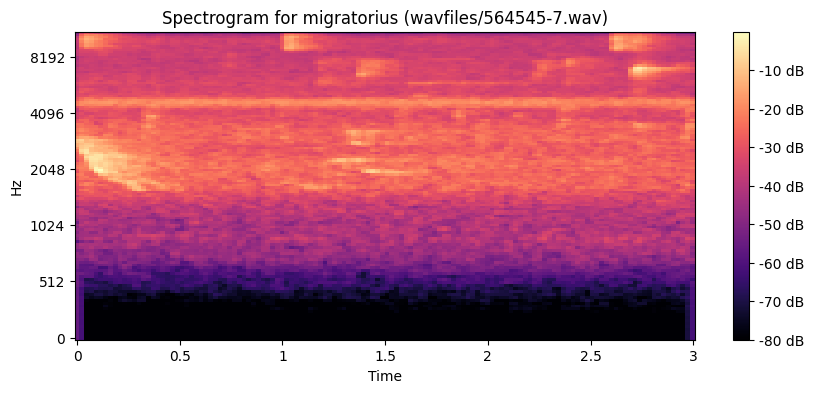

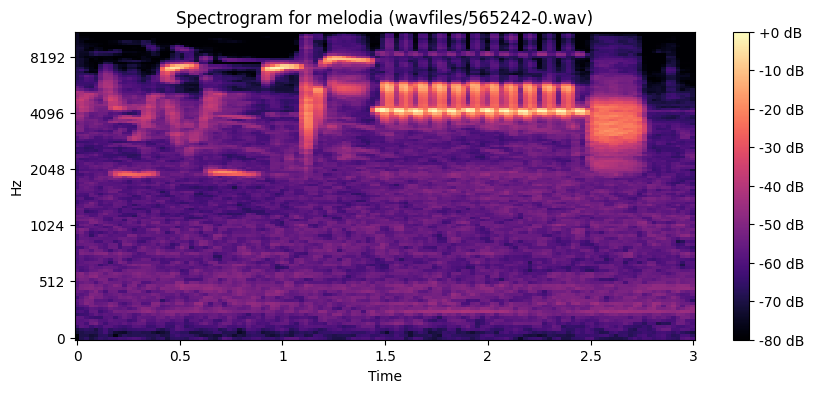

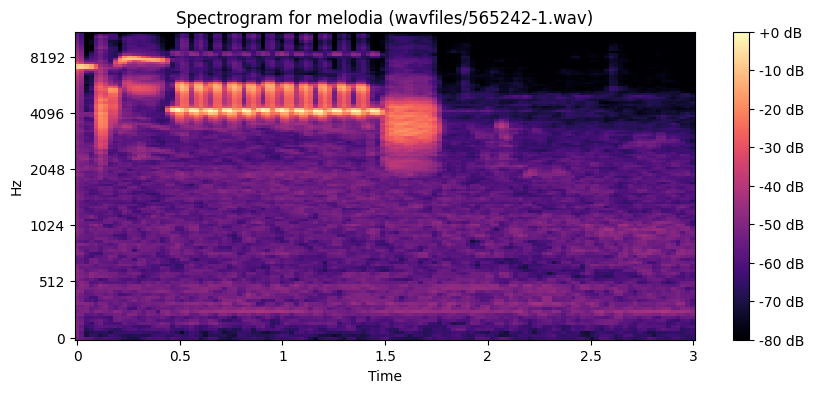

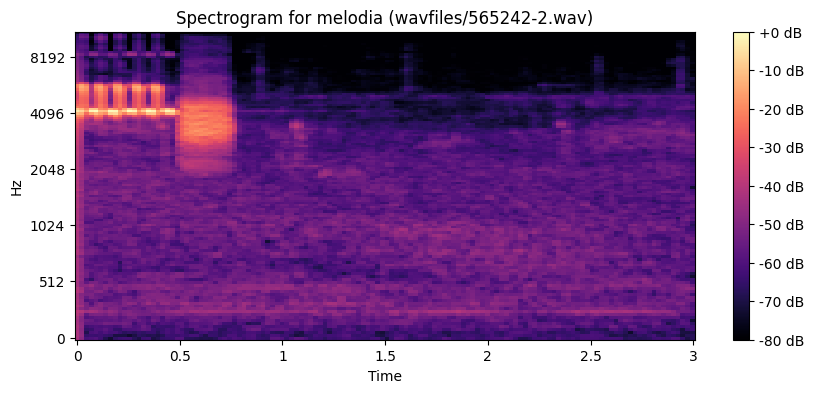

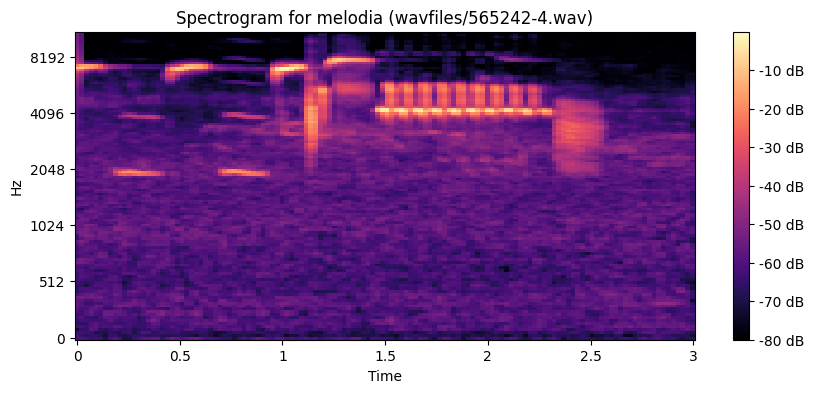

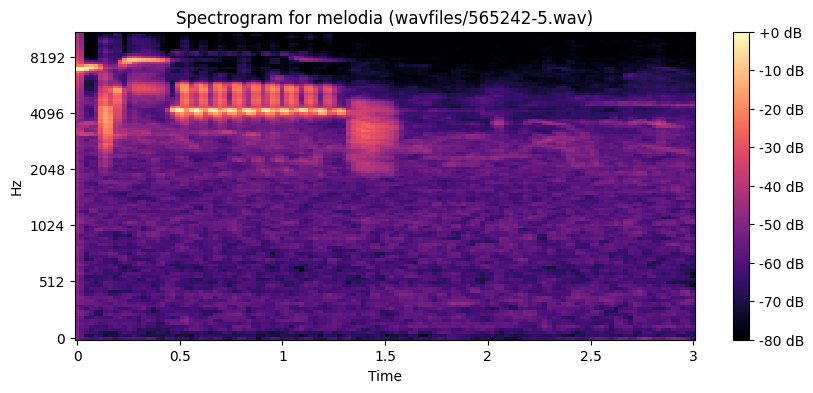

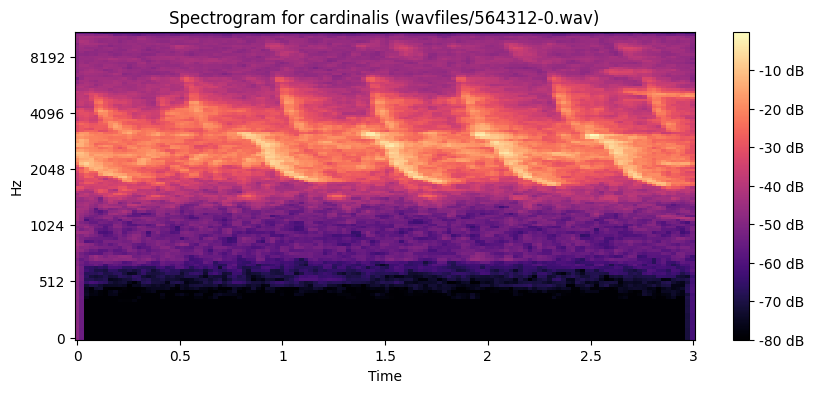

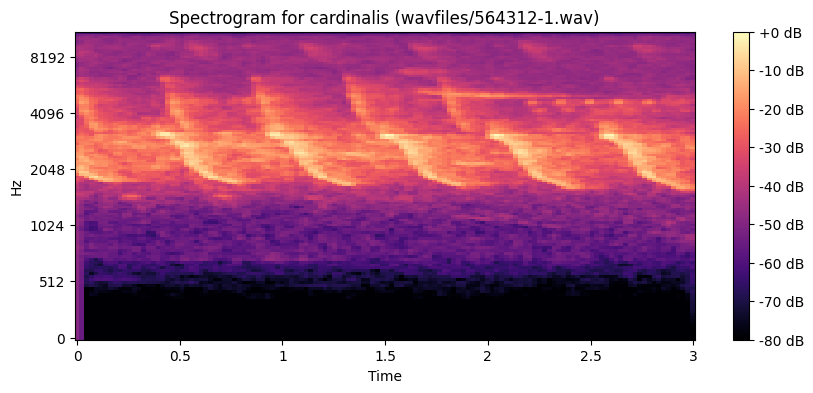

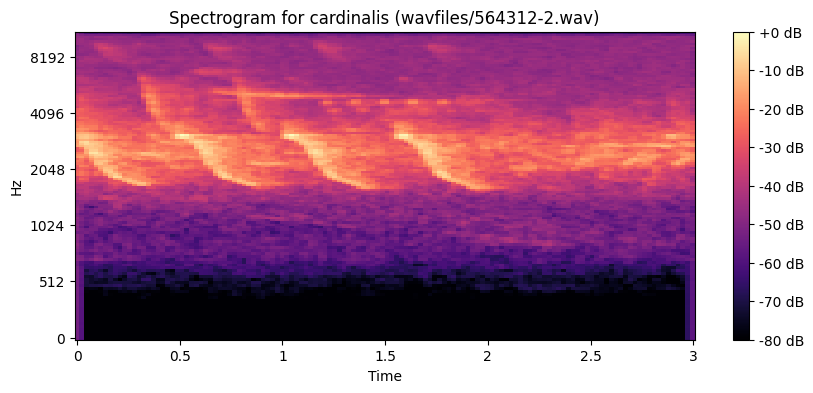

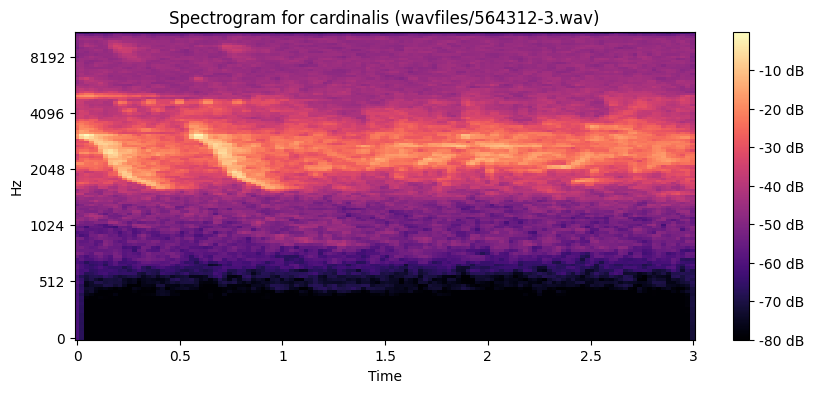

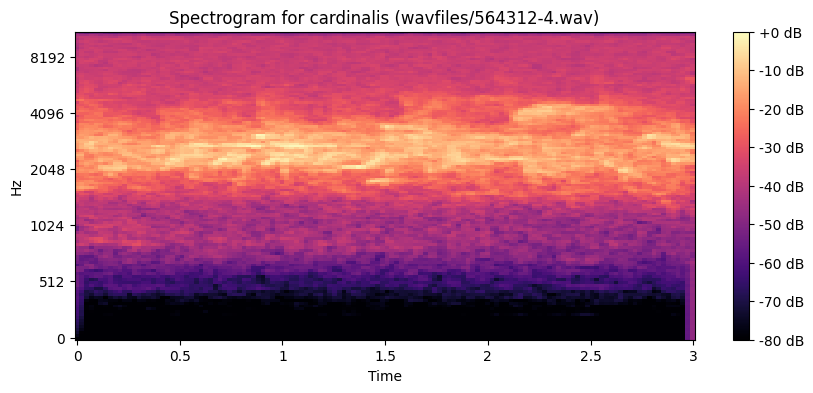

In [7]:
# Function to extract and plot Mel spectrograms
def extract_and_plot_spectrograms(metadata, zip_path):
    species_count = defaultdict(int)
    max_plots_per_species = 5

    with zipfile.ZipFile(zip_path, 'r') as z:
        for index, row in metadata.iterrows():
            species = row['species']
            if species_count[species] < max_plots_per_species:
                file_path = os.path.join('wavfiles', row['filename'])
                if file_path in z.namelist():
                    with z.open(file_path) as file:
                        y, sr = librosa.load(file, sr=None)
                        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                        S_DB = librosa.power_to_db(S, ref=np.max)

                        plt.figure(figsize=(10, 4))
                        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
                        plt.colorbar(format='%+2.0f dB')
                        plt.title(f'Spectrogram for {species} ({file_path})')
                        plt.show()

                        species_count[species] += 1


extract_and_plot_spectrograms(metadata, zip_path)

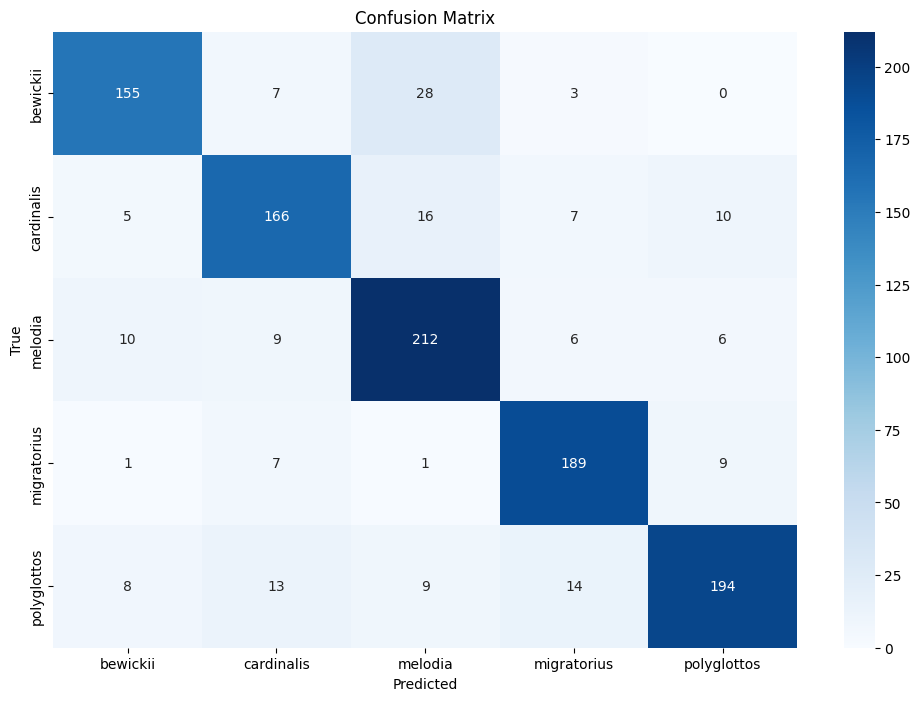

In [8]:
# Function to extract features from audio files
def extract_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return np.mean(S_DB, axis=1)  # Using mean as a simple feature

# Prepare dataset
features = []
labels = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            features.append(extract_features(file_path, z))
            labels.append(row['species'])

features = np.array(features)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and compute confusion matrix
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


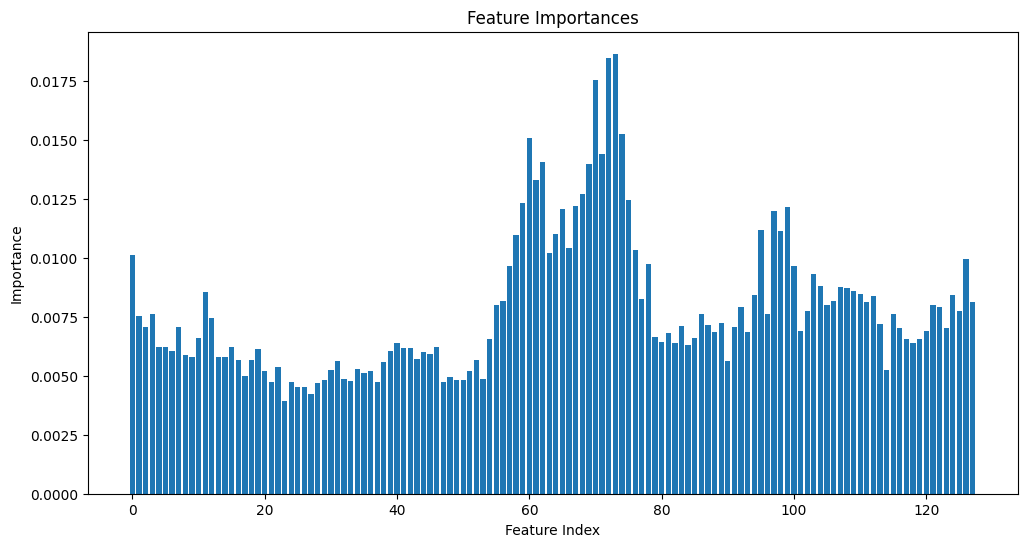

In [9]:
# Compute and plot feature importances
feature_importances = clf.feature_importances_

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


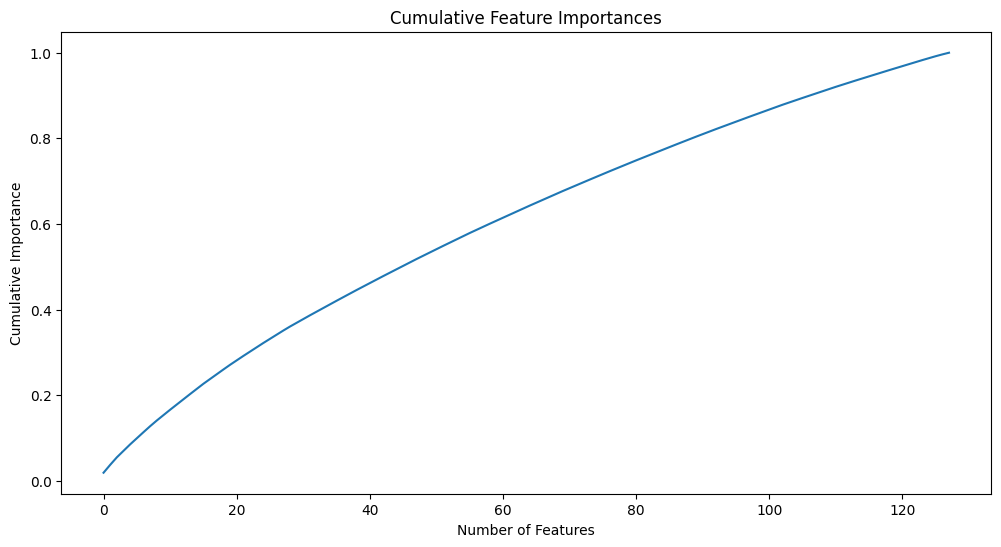

In [10]:
# Compute cumulative feature importances
sorted_indices = np.argsort(feature_importances)[::-1]
cumulative_importances = np.cumsum(feature_importances[sorted_indices])

plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_importances)), cumulative_importances)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importances')
plt.show()


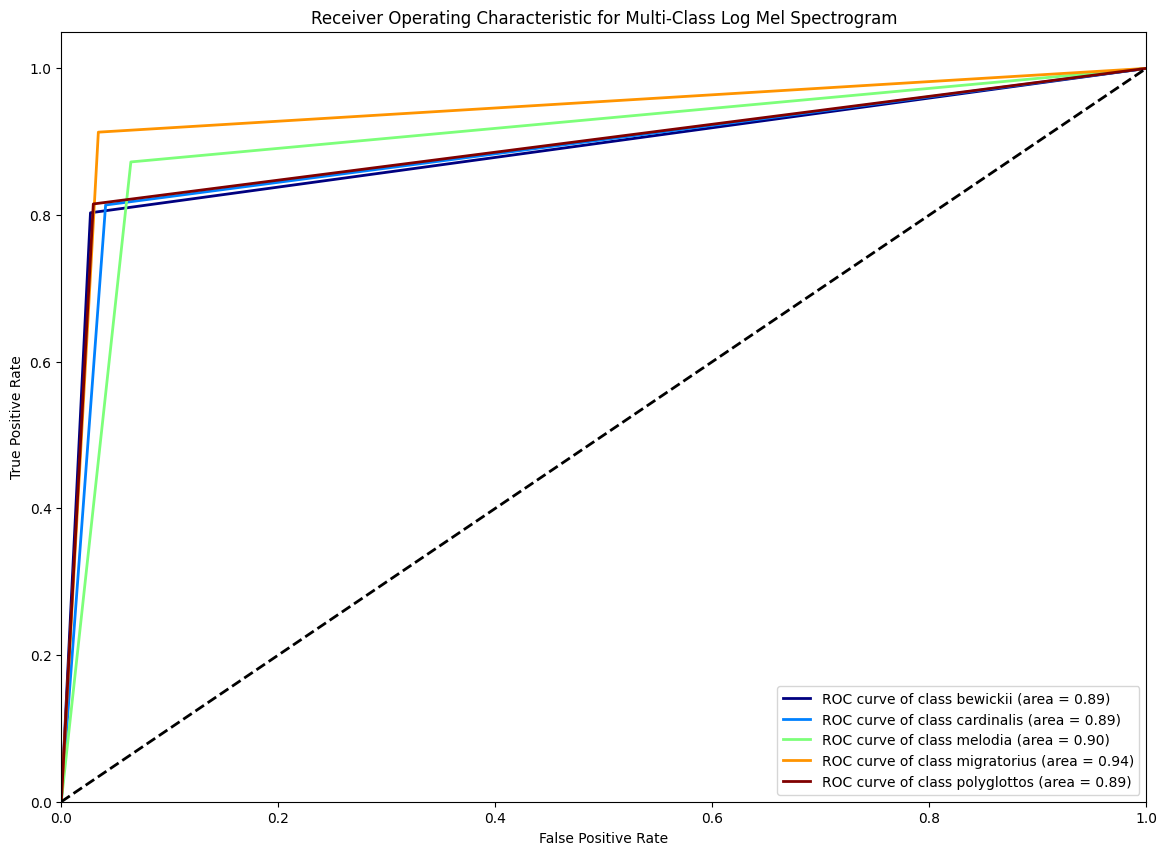

In [11]:
# Binarize the output labels for ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_bin = label_binarize(y_pred, classes=np.arange(len(label_encoder.classes_)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(14, 10))
colors = plt.cm.jet(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Log Mel Spectrogram')
plt.legend(loc="lower right")
plt.show()


In [12]:
# Define function to extract MFCC features
def extract_mfcc_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Using mean as a simple feature
        return mfcc_mean

# Prepare dataset for MFCC features
mfcc_features = []
labels_mfcc = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            mfcc_features.append(extract_mfcc_features(file_path, z))
            labels_mfcc.append(row['species'])

mfcc_features = np.array(mfcc_features)
label_encoder_mfcc = LabelEncoder()
labels_encoded_mfcc = label_encoder_mfcc.fit_transform(labels_mfcc)

# Split the dataset for MFCC features
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(mfcc_features, labels_encoded_mfcc, test_size=0.2, random_state=42)

# Train a classifier on MFCC features
clf_mfcc = RandomForestClassifier(n_estimators=100, random_state=42)
clf_mfcc.fit(X_train_mfcc, y_train_mfcc)

# Predict and compute confusion matrix for MFCC
y_pred_mfcc = clf_mfcc.predict(X_test_mfcc)
conf_matrix_mfcc = confusion_matrix(y_test_mfcc, y_pred_mfcc)

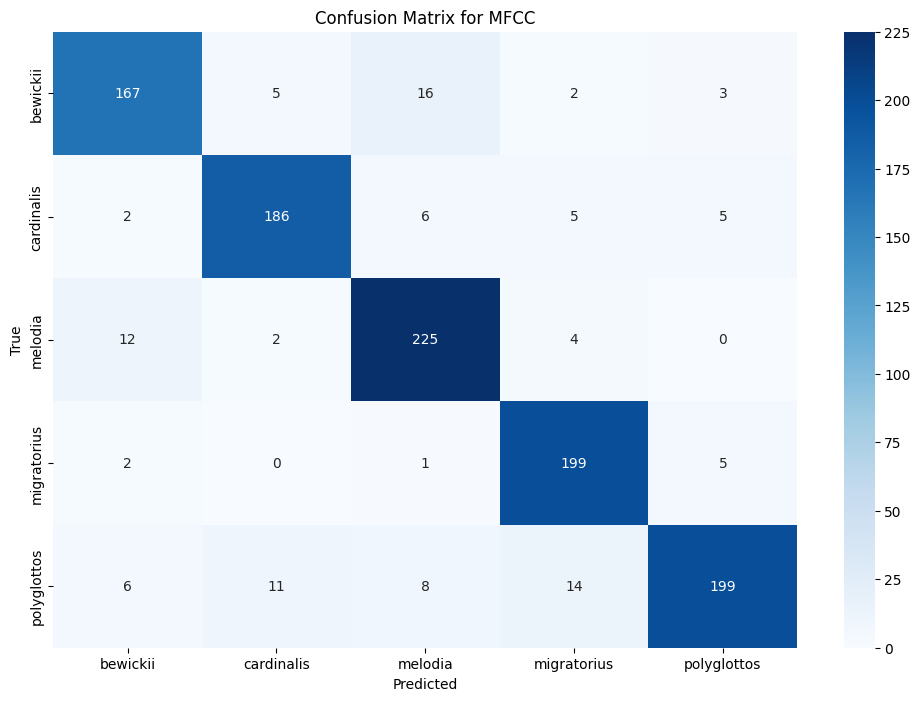

In [13]:
# Plot confusion matrix for MFCC
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_mfcc, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_mfcc.classes_, yticklabels=label_encoder_mfcc.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MFCC')
plt.show()

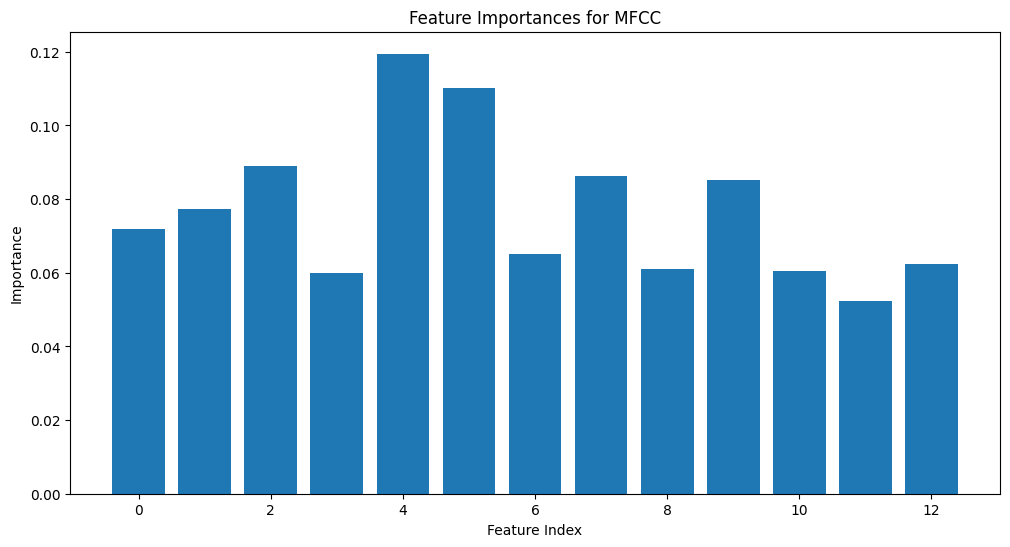

In [14]:
# Compute and plot feature importances for MFCC
feature_importances_mfcc = clf_mfcc.feature_importances_

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances_mfcc)), feature_importances_mfcc)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances for MFCC')
plt.show()


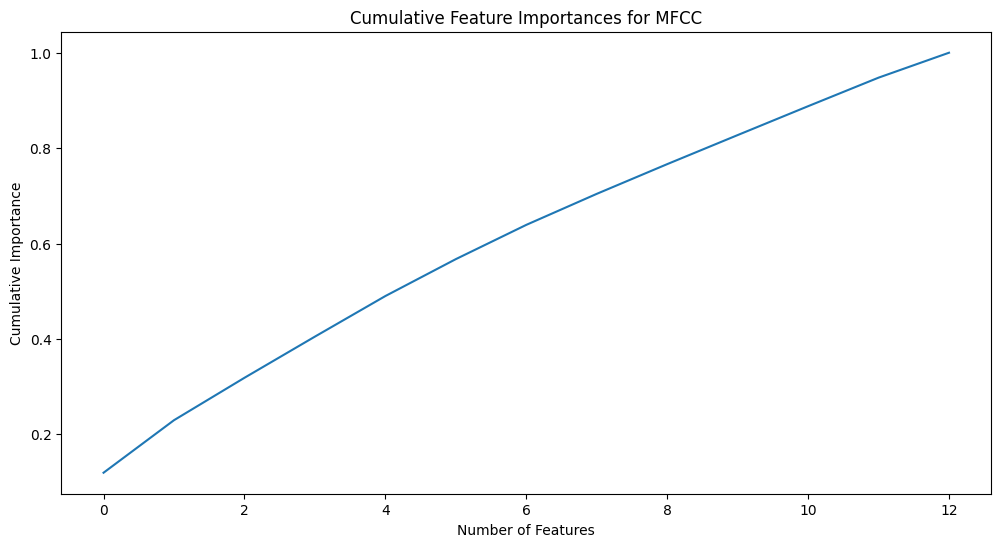

In [15]:
# Compute cumulative feature importances for MFCC
sorted_indices_mfcc = np.argsort(feature_importances_mfcc)[::-1]
cumulative_importances_mfcc = np.cumsum(feature_importances_mfcc[sorted_indices_mfcc])

plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_importances_mfcc)), cumulative_importances_mfcc)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importances for MFCC')
plt.show()

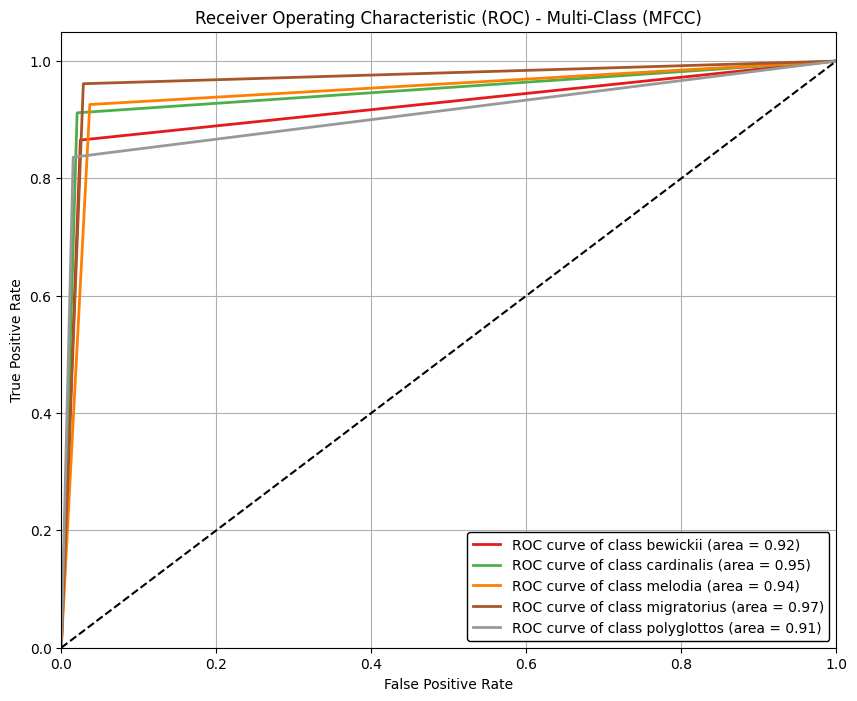

In [16]:
# Binarize the output labels for ROC curve
y_test_mfcc_bin = label_binarize(y_test_mfcc, classes=np.arange(len(label_encoder_mfcc.classes_)))
y_pred_mfcc_bin = label_binarize(y_pred_mfcc, classes=np.arange(len(label_encoder_mfcc.classes_)))

# Compute ROC curve and ROC area for each class for MFCC
fpr_mfcc = dict()
tpr_mfcc = dict()
roc_auc_mfcc = dict()
n_classes = y_test_mfcc_bin.shape[1]

for i in range(n_classes):
    fpr_mfcc[i], tpr_mfcc[i], _ = roc_curve(y_test_mfcc_bin[:, i], y_pred_mfcc_bin[:, i])
    roc_auc_mfcc[i] = auc(fpr_mfcc[i], tpr_mfcc[i])

# Plot ROC curves for MFCC
plt.figure(figsize=(10, 8))
colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_mfcc[i], tpr_mfcc[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder_mfcc.classes_[i]} (area = {roc_auc_mfcc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class (MFCC)')
plt.legend(loc="lower right", frameon=True, framealpha=1.0, edgecolor='black')
plt.grid(True)
plt.show()

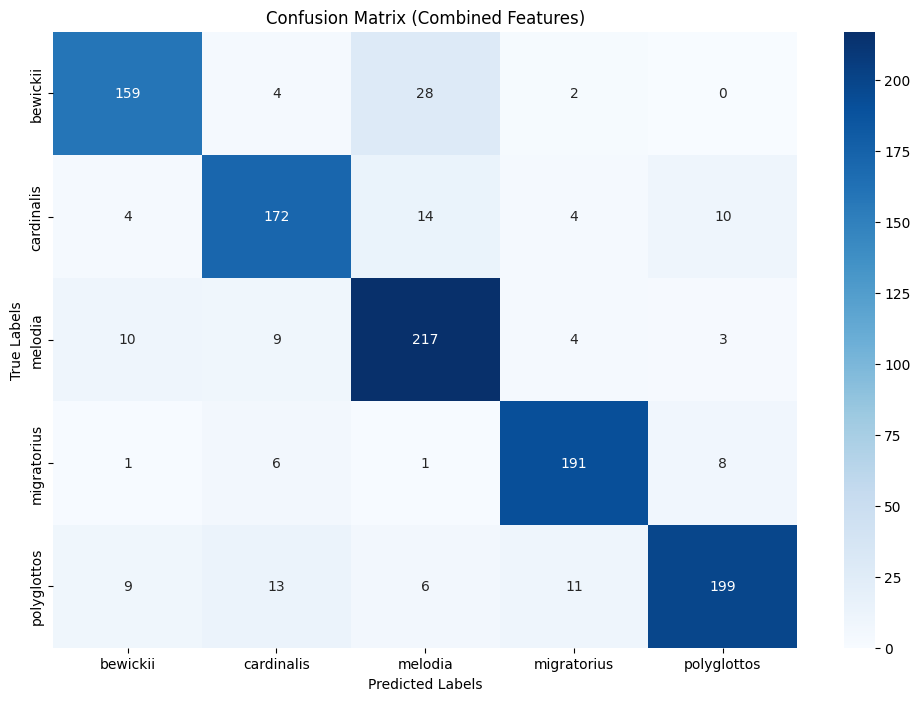

In [17]:
# Define function to extract Log Mel spectrogram features
def extract_log_mel_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return np.mean(S_DB, axis=1)

# Prepare dataset with combined features (MFCC + Log Mel)
combined_features = []
labels_combined = []  # Use a new list to avoid confusion

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            mfcc = extract_mfcc_features(file_path, z)
            log_mel = extract_log_mel_features(file_path, z)
            combined_features.append(np.concatenate([mfcc, log_mel]))
            labels_combined.append(row['species'])  # Append to the new labels list

combined_features = np.array(combined_features)
label_encoder_combined = LabelEncoder()  # Use a new label encoder
labels_encoded_combined = label_encoder_combined.fit_transform(labels_combined)

# Split the dataset
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_features, labels_encoded_combined, test_size=0.2, random_state=42)

# Train a classifier on combined features
clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
clf_combined.fit(X_train_combined, y_train_combined)

# Predict and compute confusion matrix for combined features
y_pred_combined = clf_combined.predict(X_test_combined)
conf_matrix_combined = confusion_matrix(y_test_combined, y_pred_combined)

# Plot confusion matrix for combined features
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_combined.classes_, yticklabels=label_encoder_combined.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Combined Features)')
plt.show()

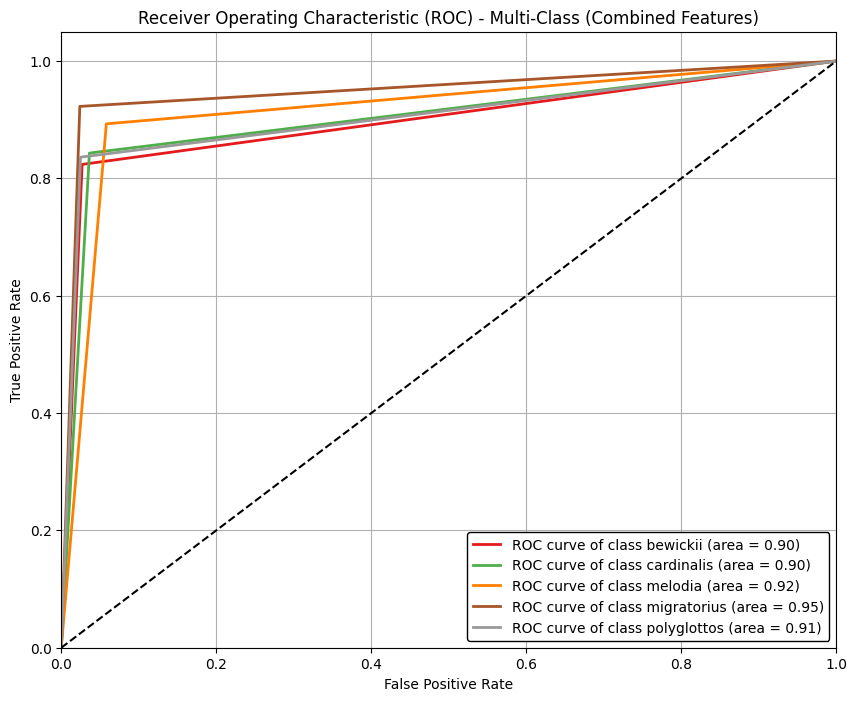

In [18]:
# Binarize the output labels for ROC curve
y_test_combined_bin = label_binarize(y_test_combined, classes=np.arange(len(label_encoder_combined.classes_)))
y_pred_combined_bin = label_binarize(y_pred_combined, classes=np.arange(len(label_encoder_combined.classes_)))

# Compute ROC curve and ROC area for each class for combined features
fpr_combined = dict()
tpr_combined = dict()
roc_auc_combined = dict()
n_classes = y_test_combined_bin.shape[1]

for i in range(n_classes):
    fpr_combined[i], tpr_combined[i], _ = roc_curve(y_test_combined_bin[:, i], y_pred_combined_bin[:, i])
    roc_auc_combined[i] = auc(fpr_combined[i], tpr_combined[i])

# Plot ROC curves for combined features
plt.figure(figsize=(10, 8))
colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_combined[i], tpr_combined[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder_combined.classes_[i]} (area = {roc_auc_combined[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class (Combined Features)')
plt.legend(loc="lower right", frameon=True, framealpha=1.0, edgecolor='black')
plt.grid(True)
plt.show()

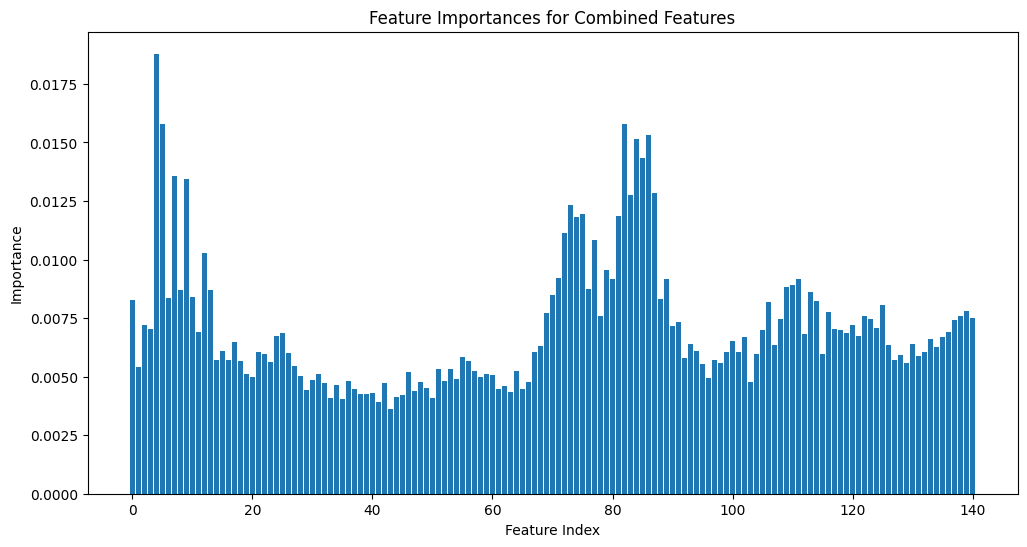

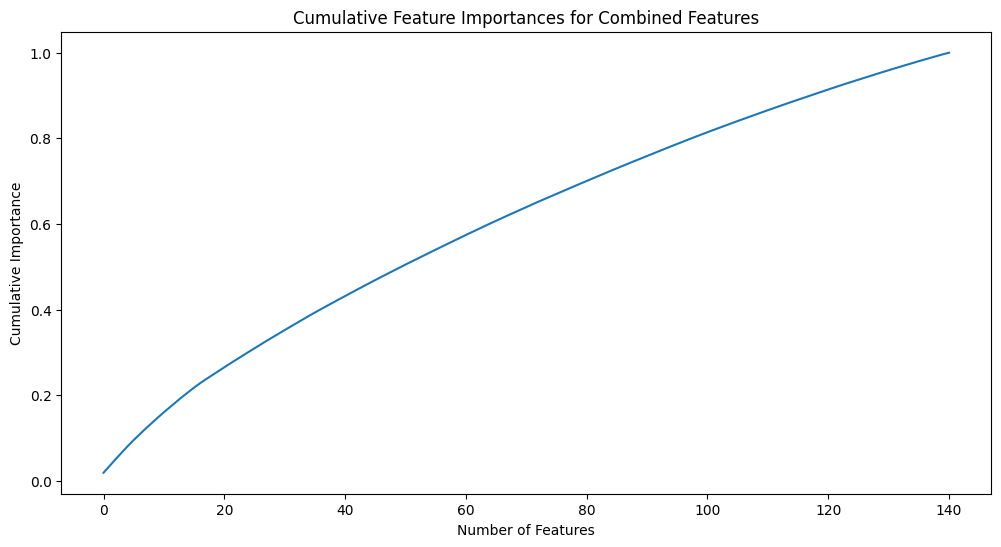

In [19]:
# Compute and plot feature importances for combined features
feature_importances_combined = clf_combined.feature_importances_

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances_combined)), feature_importances_combined)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances for Combined Features')
plt.show()

# Compute cumulative feature importances for combined features
sorted_indices_combined = np.argsort(feature_importances_combined)[::-1]
cumulative_importances_combined = np.cumsum(feature_importances_combined[sorted_indices_combined])

plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_importances_combined)), cumulative_importances_combined)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importances for Combined Features')
plt.show()

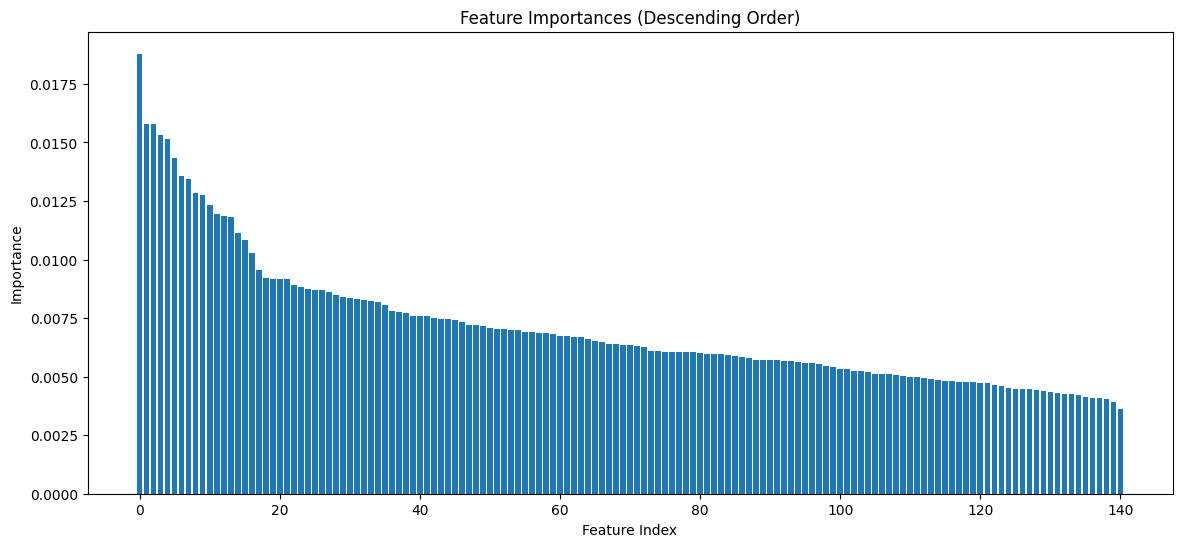

In [20]:
# Compute and plot feature importances for combined features
feature_importances_combined = clf_combined.feature_importances_

plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances_combined)), sorted(feature_importances_combined, reverse=True))
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances (Descending Order)')
plt.show()


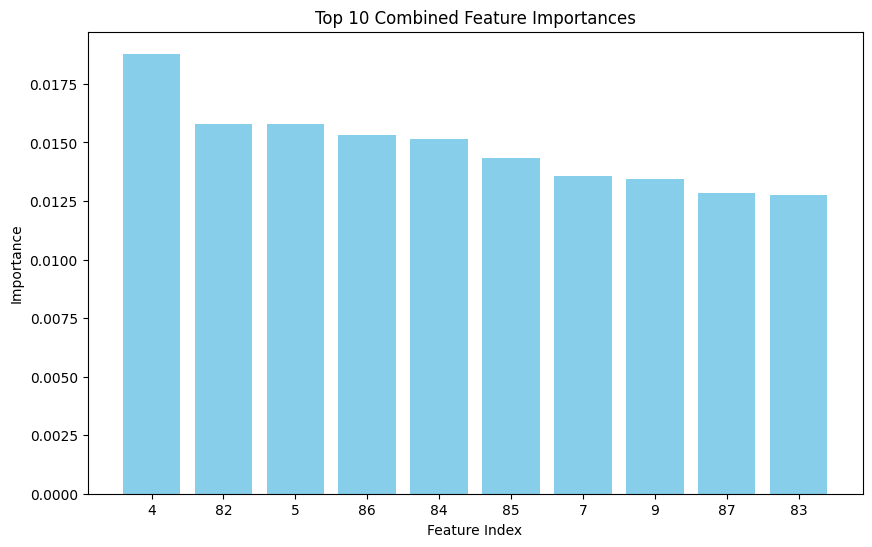

In [21]:
# Get top 10 feature importances
sorted_indices_combined = np.argsort(feature_importances_combined)[::-1]
top_10_indices = sorted_indices_combined[:10]
top_10_importances = feature_importances_combined[top_10_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(10), top_10_importances, color='skyblue')
plt.xticks(range(10), top_10_indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 10 Combined Feature Importances')
plt.show()


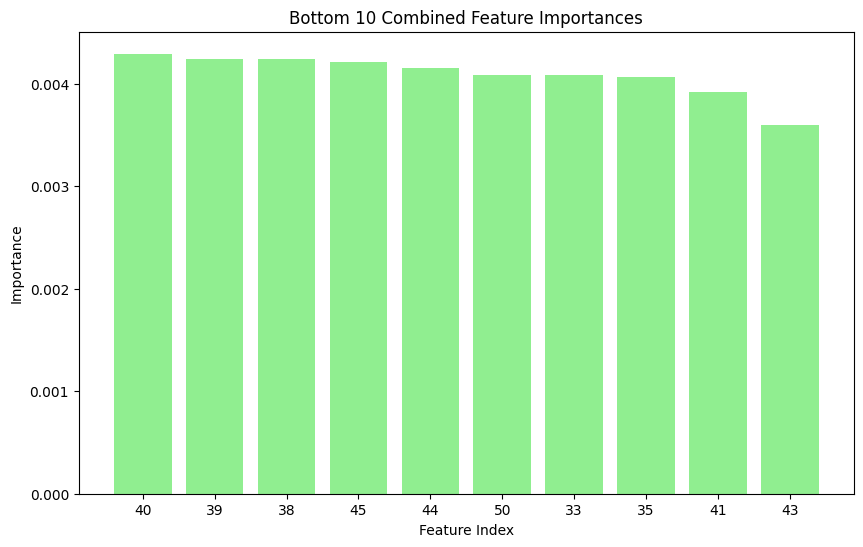

In [22]:
# Get bottom 10 feature importances
bottom_10_indices = sorted_indices_combined[-10:]
bottom_10_importances = feature_importances_combined[bottom_10_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(10), bottom_10_importances, color='lightgreen')
plt.xticks(range(10), bottom_10_indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Bottom 10 Combined Feature Importances')
plt.show()


Classification Report:
              precision    recall  f1-score   support

    bewickii       0.87      0.82      0.85       193
  cardinalis       0.84      0.84      0.84       204
     melodia       0.82      0.89      0.85       243
 migratorius       0.90      0.92      0.91       207
 polyglottos       0.90      0.84      0.87       238

    accuracy                           0.86      1085
   macro avg       0.87      0.86      0.86      1085
weighted avg       0.87      0.86      0.86      1085

Cross-validation results:
fit_time: 4.7044 (+/- 0.6218)
score_time: 0.0400 (+/- 0.0041)
test_accuracy: 0.4982 (+/- 0.0644)
test_precision_macro: 0.4983 (+/- 0.0712)
test_recall_macro: 0.4863 (+/- 0.0626)
test_f1_macro: 0.4827 (+/- 0.0678)


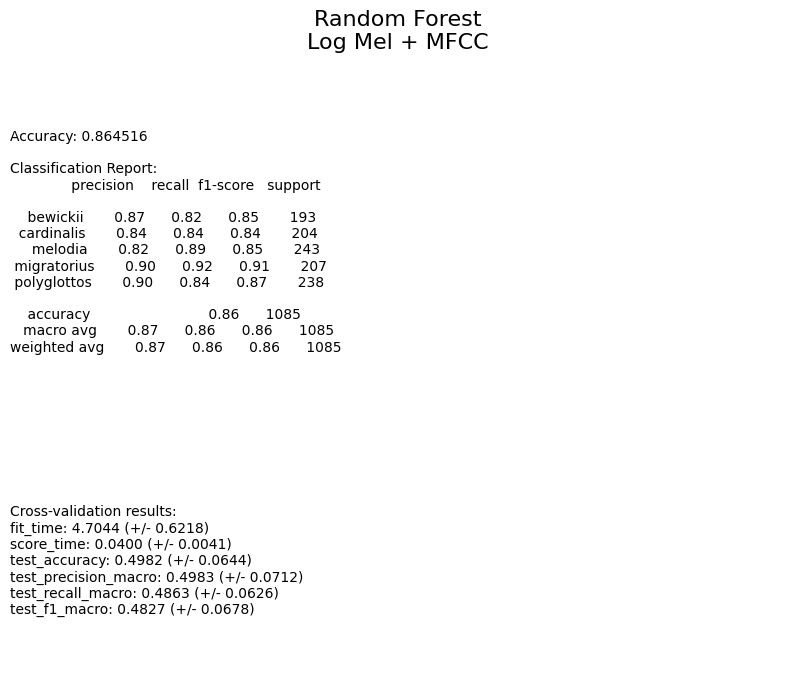

In [23]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_validate

# Predict and compute classification report for combined features
y_pred_combined = clf_combined.predict(X_test_combined)
class_report = classification_report(y_test_combined, y_pred_combined, target_names=label_encoder_combined.classes_)

# Print classification report
print(f"Classification Report:\n{class_report}")

# Cross-validation
cv_results = cross_validate(clf_combined, combined_features, labels_encoded_combined, cv=5,
                            scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

# Print cross-validation results
print(f"Cross-validation results:")
for key, value in cv_results.items():
    print(f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")

# Create a figure to display the classification report and cross-validation results
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

# Add the classification report text
classification_report_text = f"Accuracy: {accuracy_score(y_test_combined, y_pred_combined):.6f}\n\nClassification Report:\n{class_report}"
ax.text(0, 0.5, classification_report_text, ha='left', wrap=True, fontsize=10)

# Add the cross-validation results text
cv_results_text = "Cross-validation results:\n" + "\n".join(
    [f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})" for key, value in cv_results.items()])
ax.text(0, 0.1, cv_results_text, ha='left', wrap=True, fontsize=10)

plt.title("Random Forest\nLog Mel + MFCC", fontsize=16)
plt.show()


Classification Report:
              precision    recall  f1-score   support

    bewickii       0.80      0.89      0.84       193
  cardinalis       0.90      0.89      0.89       204
     melodia       0.86      0.84      0.85       243
 migratorius       0.89      0.92      0.91       207
 polyglottos       0.89      0.82      0.86       238

    accuracy                           0.87      1085
   macro avg       0.87      0.87      0.87      1085
weighted avg       0.87      0.87      0.87      1085



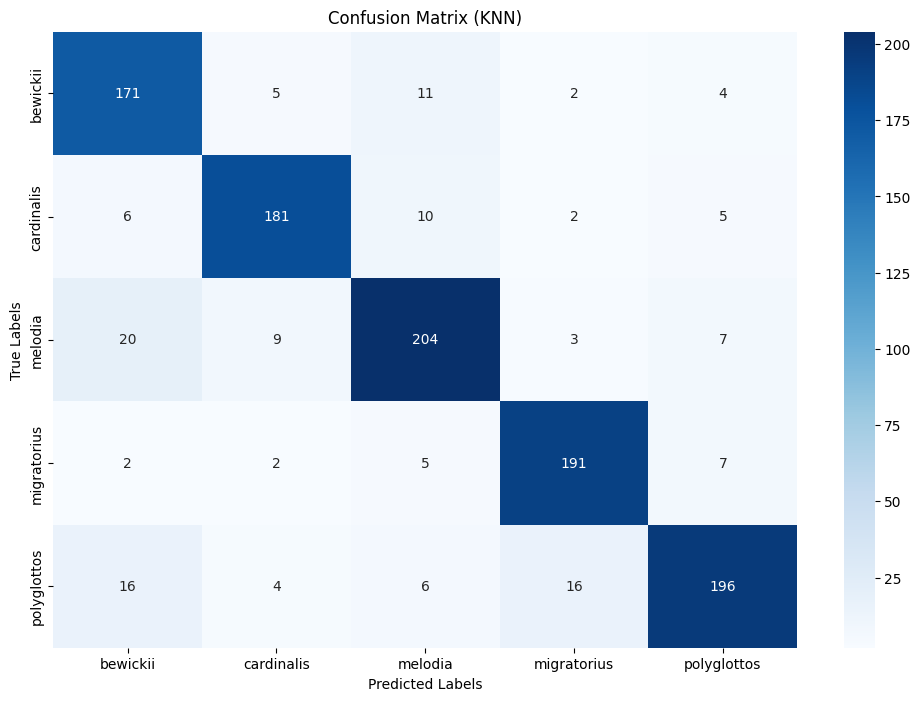

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train a KNN classifier on combined features
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_combined, y_train_combined)

# Predict and compute confusion matrix for combined features
y_pred_knn = knn_classifier.predict(X_test_combined)
conf_matrix_knn = confusion_matrix(y_test_combined, y_pred_knn)

# Classification report
class_report_knn = classification_report(y_test_combined, y_pred_knn, target_names=label_encoder_combined.classes_)

# Print classification report
print(f"Classification Report:\n{class_report_knn}")

# Plot confusion matrix for KNN
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_combined.classes_, yticklabels=label_encoder_combined.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (KNN)')
plt.show()


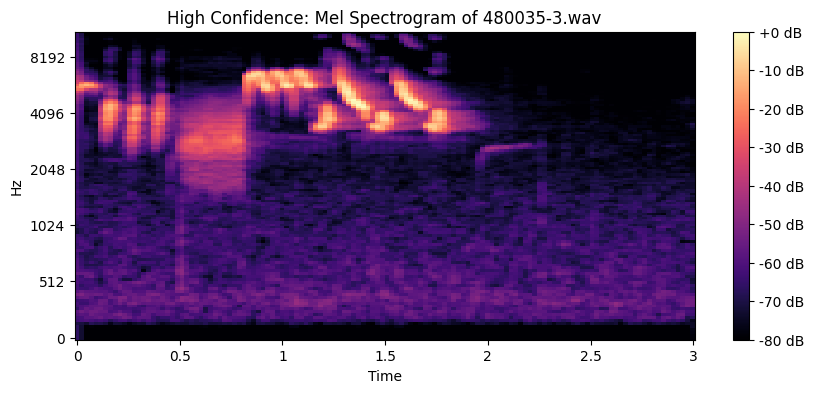

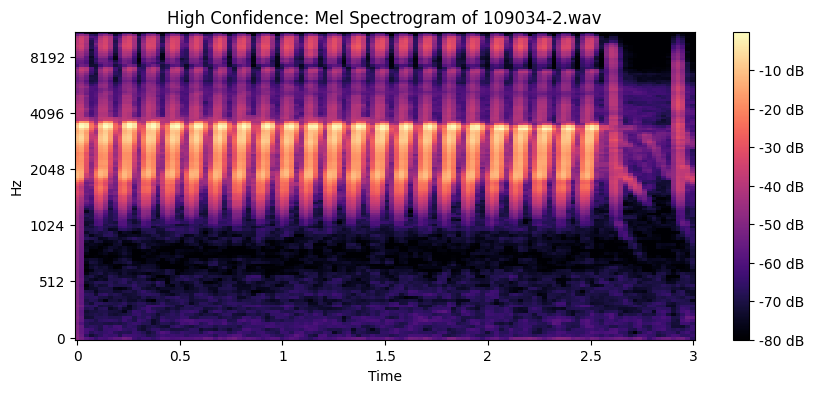

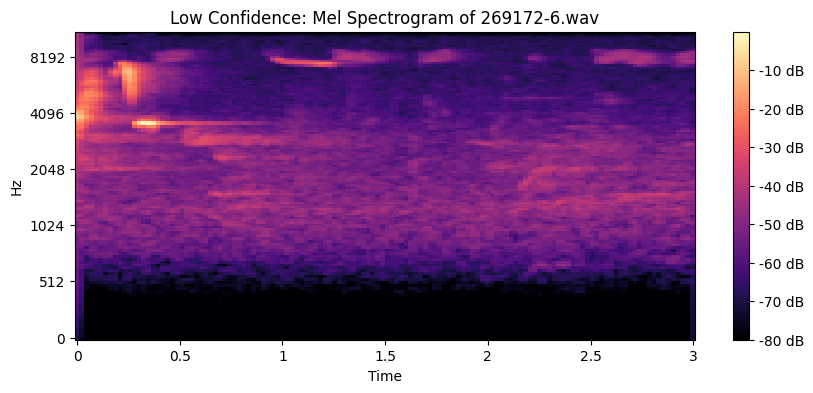

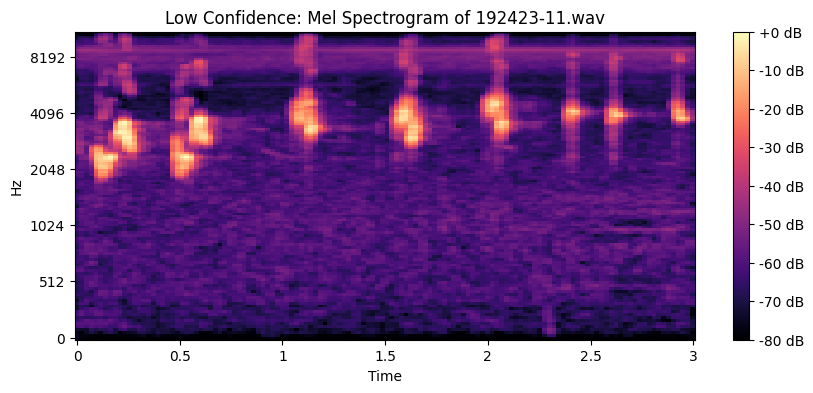

In [25]:
# Predict probabilities
y_prob_knn = knn_classifier.predict_proba(X_test_combined)
y_pred_knn = knn_classifier.predict(X_test_combined)

# Calculate confidence scores as the maximum probability
confidence_scores = np.max(y_prob_knn, axis=1)

# Get indices of high and low confidence predictions
high_confidence_indices = np.argsort(confidence_scores)[-2:]  # Top 2 high confidence
low_confidence_indices = np.argsort(confidence_scores)[:2]   # Top 2 low confidence

# Function to plot Mel spectrogram
def plot_mel_spectrogram(file_path, zip_ref, title):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.show()

# Get the original indices of the test set
_, X_test_indices, _, y_test_indices = train_test_split(np.arange(len(labels_encoded_combined)), labels_encoded_combined, test_size=0.2, random_state=42)

# Plot high and low confidence Mel spectrograms
with zipfile.ZipFile(zip_path, 'r') as z:
    for idx in high_confidence_indices:
        original_index = X_test_indices[idx]
        file_name = metadata.iloc[original_index]['filename']
        file_path = os.path.join('wavfiles', file_name)
        plot_mel_spectrogram(file_path, z, f"High Confidence: Mel Spectrogram of {file_name}")

    for idx in low_confidence_indices:
        original_index = X_test_indices[idx]
        file_name = metadata.iloc[original_index]['filename']
        file_path = os.path.join('wavfiles', file_name)
        plot_mel_spectrogram(file_path, z, f"Low Confidence: Mel Spectrogram of {file_name}")


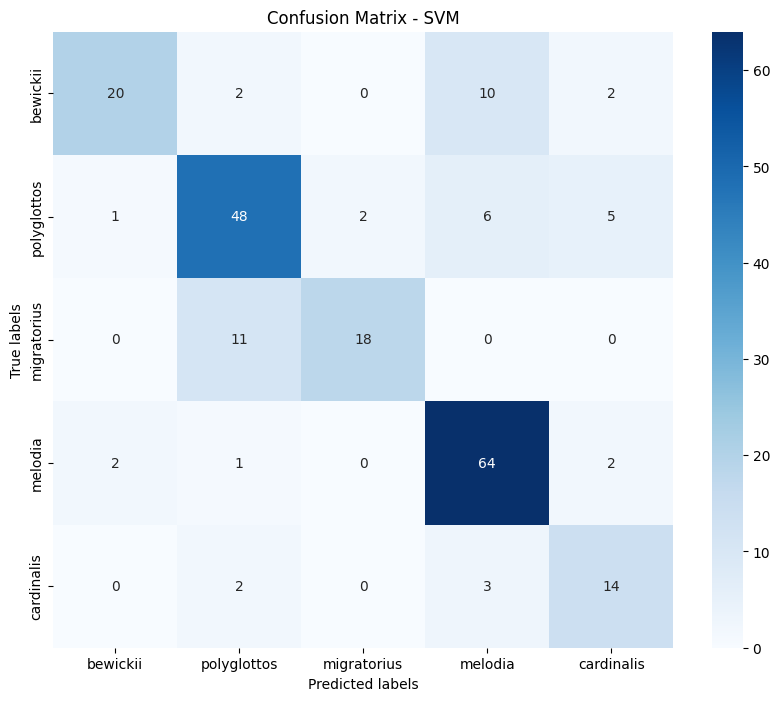

In [3]:
import pandas as pd
import numpy as np
import librosa
import os
import zipfile
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'  # Update this to your actual metadata path
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'  # Update this to your actual zip file path
metadata = pd.read_csv(metadata_path)

# Function to extract features from audio files
def extract_features(zip_path, metadata):
    features = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for _, row in metadata.iterrows():
            file_path = os.path.join('wavfiles', row['filename'])  # Adjust according to how your filenames are stored in metadata
            if file_path in z.namelist():
                with z.open(file_path) as file:
                    y, sr = librosa.load(file, sr=None)
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                    mfccs_mean = np.mean(mfccs, axis=1)
                    features.append(mfccs_mean)
    return features

# Extract features
features = extract_features(zip_path, metadata)
if not features:
    print("No features were extracted. Check the file paths and contents of the zip file.")
else:
    mfccs_df = pd.DataFrame(features, columns=[f'mfcc_{i}' for i in range(13)])
    metadata = pd.concat([metadata, mfccs_df], axis=1).dropna().reset_index(drop=True)

# Prepare the data
X = metadata[[f'mfcc_{i}' for i in range(13)]]
y = pd.factorize(metadata['species'])[0]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
model = svm.SVC(kernel='linear', probability=True)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = model.predict(X_test_scaled)

# Compute confusion matrix
species_labels = metadata['species'].unique()
cm = confusion_matrix(y_test, y_pred_svm, labels=np.arange(len(species_labels)))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=species_labels, yticklabels=species_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM')
plt.show()



In [4]:
from sklearn.metrics import classification_report

# Generate classification report
class_report_svm = classification_report(y_test, y_pred_svm, target_names=species_labels)

# Print classification report
print(f"Classification Report:\n{class_report_svm}")


Classification Report:
              precision    recall  f1-score   support

    bewickii       0.87      0.59      0.70        34
 polyglottos       0.75      0.77      0.76        62
 migratorius       0.90      0.62      0.73        29
     melodia       0.77      0.93      0.84        69
  cardinalis       0.61      0.74      0.67        19

    accuracy                           0.77       213
   macro avg       0.78      0.73      0.74       213
weighted avg       0.78      0.77      0.77       213



In [6]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.4 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 5422/5422 [01:46<00:00, 50.94it/s]


Processed 5422 files successfully.
Skipped 0 files due to errors.


  0%|          | 0/213 [00:00<?, ?it/s]

<Figure size 1000x800 with 0 Axes>

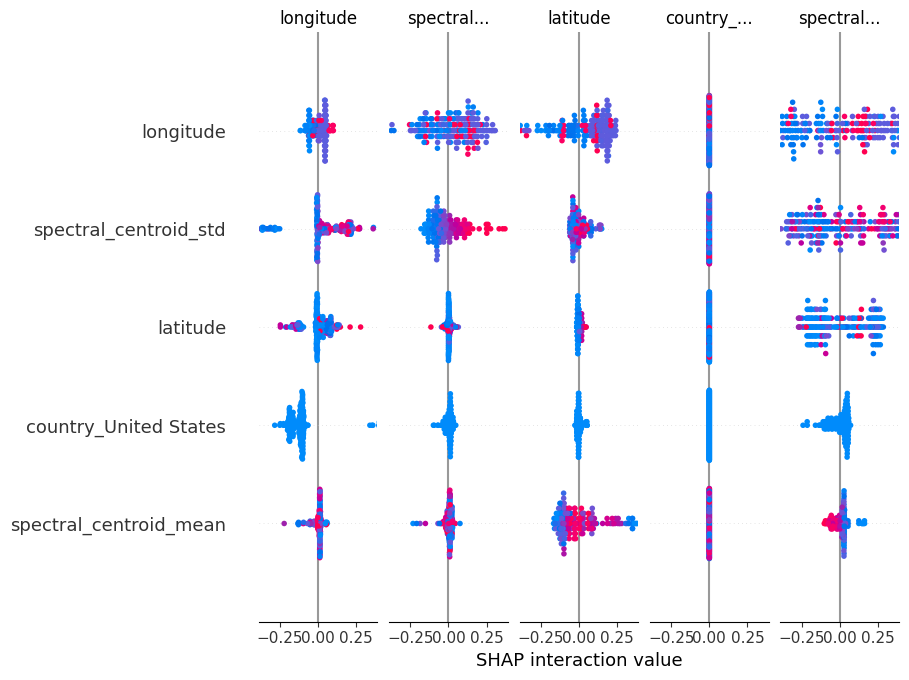

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
import shap

# Load metadata
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata = pd.read_csv(metadata_path)

# Filter metadata to include only species of interest
species_of_interest = ['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis']
metadata = metadata[metadata['species'].isin(species_of_interest)]

# Extract features from the audio files
def extract_features(zip_path, metadata):
    features = []
    error_files = []  # To keep track of files that cause errors

    with zipfile.ZipFile(zip_path, 'r') as z:
        for _, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
            file_path = os.path.join('wavfiles', row['filename'])
            if file_path in z.namelist():
                try:
                    with z.open(file_path) as file:
                        y, sr = librosa.load(file, sr=None)
                        # Ensure there's enough audio to process
                        if len(y) > 0:
                            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                            if spectral_centroid.size > 0:
                                features.append([np.mean(spectral_centroid), np.std(spectral_centroid)])
                            else:
                                error_files.append(file_path)
                        else:
                            error_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_files.append(file_path)
    return features, error_files

# Extract features and get the list of error files
features, error_files = extract_features(zip_path, metadata)

# Create DataFrame from extracted features
if features:
    features_df = pd.DataFrame(features, columns=['spectral_centroid_mean', 'spectral_centroid_std'])
    # Remove entries from metadata that caused errors
    metadata = metadata[metadata['filename'].apply(lambda x: x not in error_files)].reset_index(drop=True)
    # Append features to the metadata DataFrame
    metadata = pd.concat([metadata, features_df], axis=1)
    print(f"Processed {len(features)} files successfully.")
    print(f"Skipped {len(error_files)} files due to errors.")
else:
    print("No features were extracted. Check the file paths and contents of the zip file.")

# Remove rows with NaN values
metadata = metadata.dropna().reset_index(drop=True)

# Prepare the data for training
X = metadata[['latitude', 'longitude', 'spectral_centroid_mean', 'spectral_centroid_std', 'country']]
y = pd.factorize(metadata['species'])[0]

# Convert categorical features to numerical
X = pd.get_dummies(X, columns=['country'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
model = svm.SVC(kernel='linear', probability=True)
model.fit(X_train_scaled, y_train)

# Create SHAP explainer
explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
plt.show()


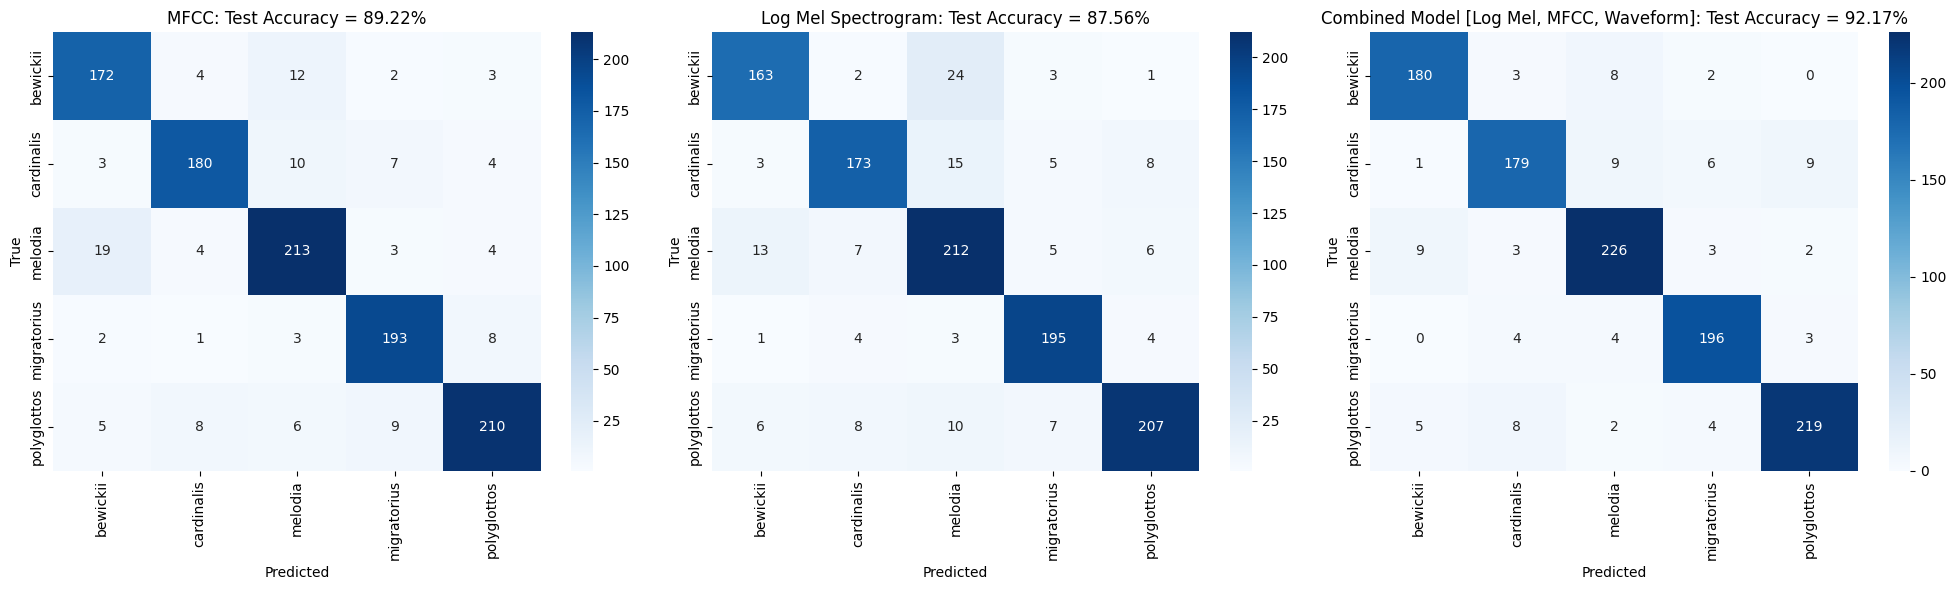

In [8]:
import pandas as pd
import numpy as np
import librosa
import os
import zipfile
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata = pd.read_csv(metadata_path)

# Function to extract MFCC features
def extract_mfcc_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        return mfcc_mean

# Function to extract Log Mel spectrogram features
def extract_log_mel_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return np.mean(S_DB, axis=1)

# Function to extract waveform features (simple mean)
def extract_waveform_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        waveform_mean = np.mean(y)
        return np.array([waveform_mean])

# Prepare dataset for MFCC, Log Mel, and Waveform features
mfcc_features = []
log_mel_features = []
waveform_features = []
labels = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            mfcc = extract_mfcc_features(file_path, z)
            log_mel = extract_log_mel_features(file_path, z)
            waveform = extract_waveform_features(file_path, z)
            mfcc_features.append(mfcc)
            log_mel_features.append(log_mel)
            waveform_features.append(waveform)
            labels.append(row['species'])

# Convert to numpy arrays
mfcc_features = np.array(mfcc_features)
log_mel_features = np.array(log_mel_features)
waveform_features = np.array(waveform_features)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split dataset for MFCC features
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(mfcc_features, labels_encoded, test_size=0.2, random_state=42)

# Split dataset for Log Mel features
X_train_log_mel, X_test_log_mel, y_train_log_mel, y_test_log_mel = train_test_split(log_mel_features, labels_encoded, test_size=0.2, random_state=42)

# Combine all features for the combined model
combined_features = np.hstack([mfcc_features, log_mel_features, waveform_features])
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_features, labels_encoded, test_size=0.2, random_state=42)

# Train and evaluate XGBoost model for MFCC features
xgb_mfcc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_mfcc.fit(X_train_mfcc, y_train_mfcc)
y_pred_mfcc = xgb_mfcc.predict(X_test_mfcc)
accuracy_mfcc = accuracy_score(y_test_mfcc, y_pred_mfcc)
conf_matrix_mfcc = confusion_matrix(y_test_mfcc, y_pred_mfcc)

# Train and evaluate XGBoost model for Log Mel features
xgb_log_mel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_log_mel.fit(X_train_log_mel, y_train_log_mel)
y_pred_log_mel = xgb_log_mel.predict(X_test_log_mel)
accuracy_log_mel = accuracy_score(y_test_log_mel, y_pred_log_mel)
conf_matrix_log_mel = confusion_matrix(y_test_log_mel, y_pred_log_mel)

# Train and evaluate XGBoost model for combined features
xgb_combined = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_combined.fit(X_train_combined, y_train_combined)
y_pred_combined = xgb_combined.predict(X_test_combined)
accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
conf_matrix_combined = confusion_matrix(y_test_combined, y_pred_combined)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(conf_matrix_mfcc, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title(f'MFCC: Test Accuracy = {accuracy_mfcc:.2%}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(conf_matrix_log_mel, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title(f'Log Mel Spectrogram: Test Accuracy = {accuracy_log_mel:.2%}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[2])
axes[2].set_title(f'Combined Model [Log Mel, MFCC, Waveform]: Test Accuracy = {accuracy_combined:.2%}')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best accuracy found: 88.26%


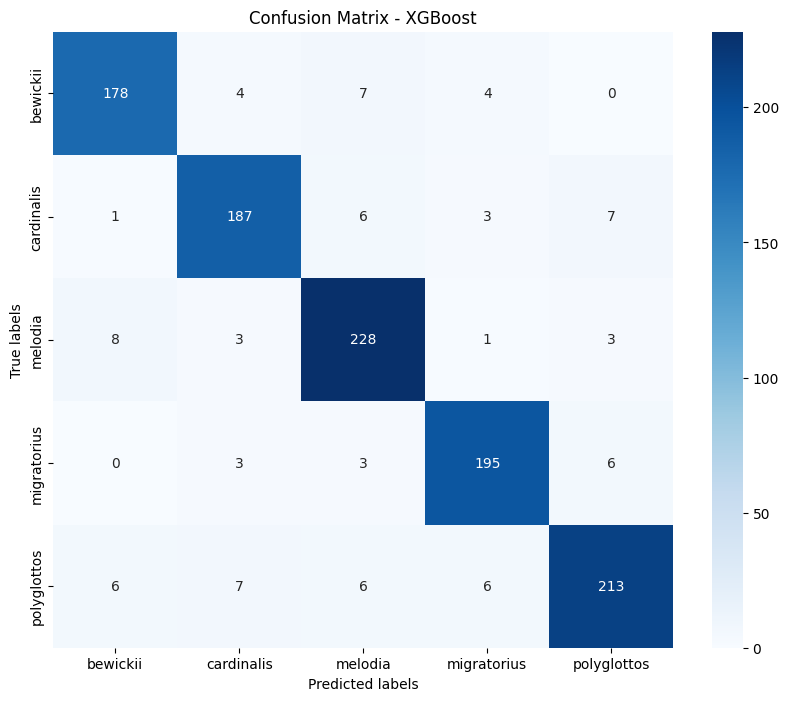

Classification Report:
              precision    recall  f1-score   support

    bewickii       0.92      0.92      0.92       193
  cardinalis       0.92      0.92      0.92       204
     melodia       0.91      0.94      0.92       243
 migratorius       0.93      0.94      0.94       207
 polyglottos       0.93      0.89      0.91       238

    accuracy                           0.92      1085
   macro avg       0.92      0.92      0.92      1085
weighted avg       0.92      0.92      0.92      1085



<Figure size 1000x800 with 0 Axes>

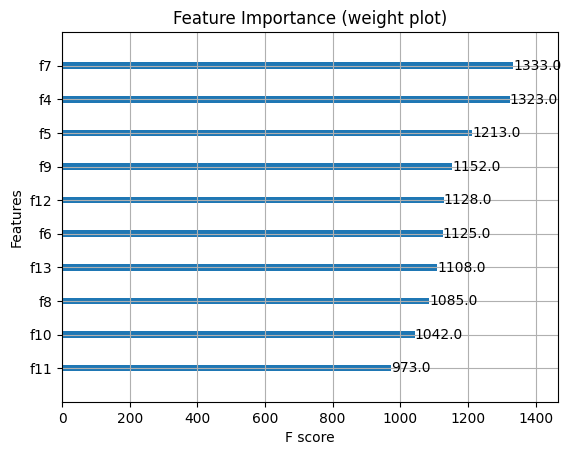

<Figure size 1500x1000 with 0 Axes>

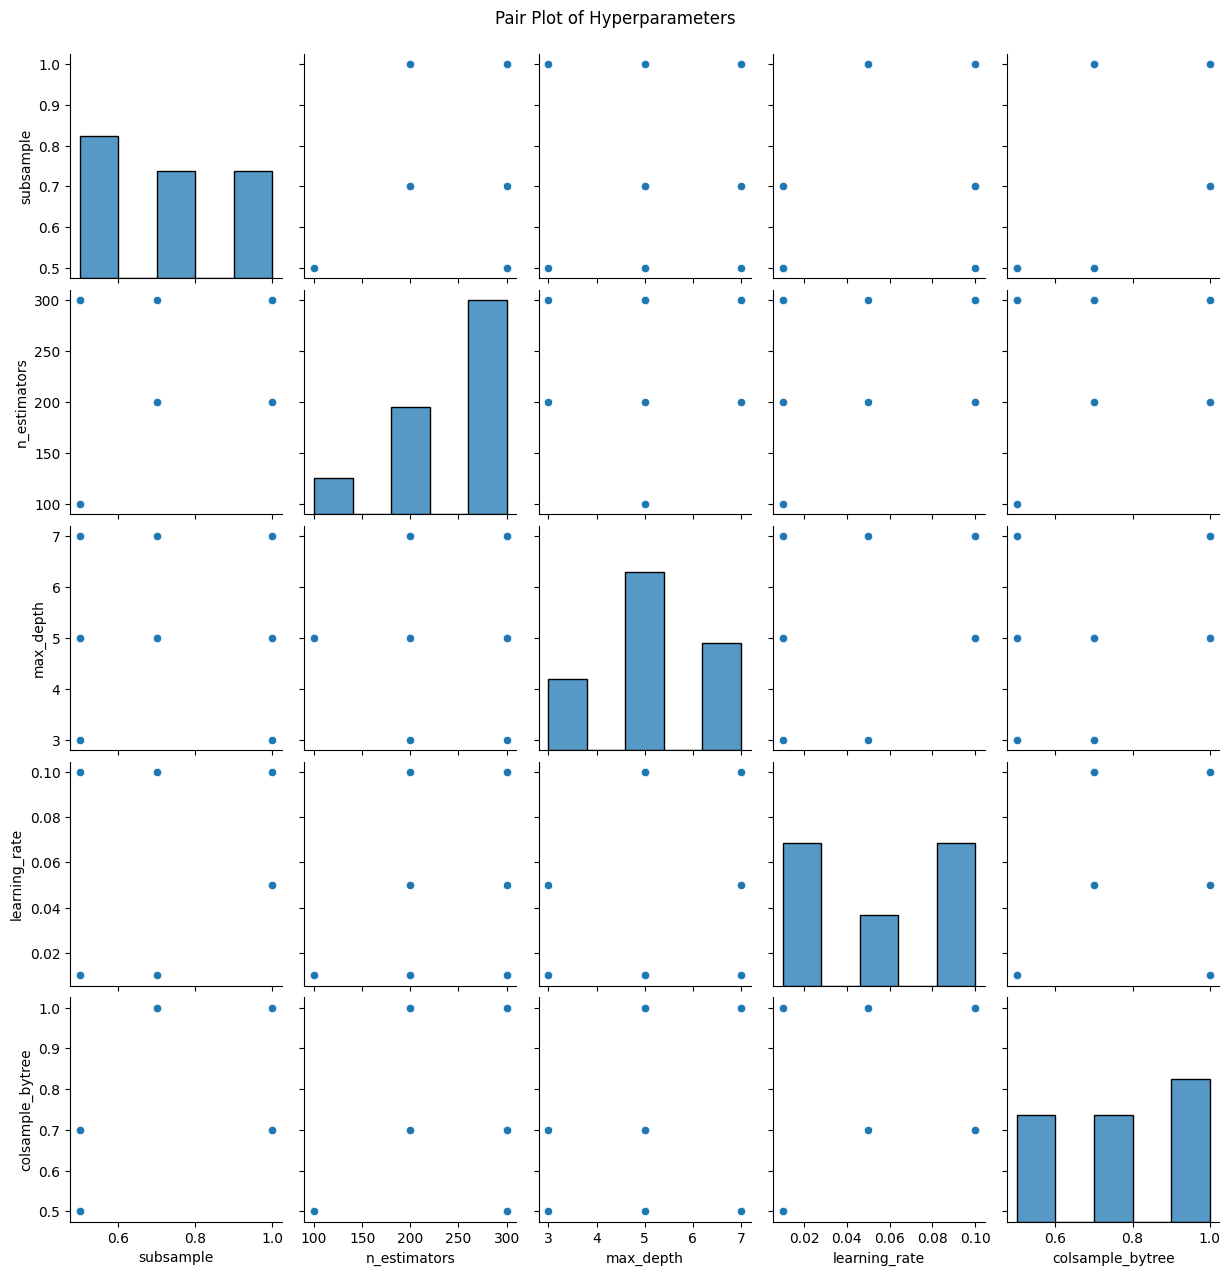

In [12]:
import pandas as pd
import numpy as np
import librosa
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
import shap

# Load metadata
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata = pd.read_csv(metadata_path)

# Function to extract MFCC features
def extract_mfcc_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        return mfcc_mean

# Extract MFCC features
mfcc_features = []
labels = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            mfcc = extract_mfcc_features(file_path, z)
            mfcc_features.append(mfcc)
            labels.append(row['species'])

# Convert to numpy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Define function to extract Log Mel spectrogram features
def extract_log_mel_features(file_path, zip_ref):
    with zip_ref.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return np.mean(S_DB, axis=1)

# Prepare dataset with combined features (MFCC + Log Mel)
combined_features = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            mfcc = extract_mfcc_features(file_path, z)
            log_mel = extract_log_mel_features(file_path, z)
            combined_features.append(np.concatenate([mfcc, log_mel]))

combined_features = np.array(combined_features)
label_encoder_combined = LabelEncoder()
labels_encoded_combined = label_encoder_combined.fit_transform(labels)

# Split the dataset for combined features (MFCC + Log Mel)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_features, labels_encoded_combined, test_size=0.2, random_state=42)

# Define XGBoost model and parameters for RandomizedSearchCV
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42)
random_search.fit(X_train_combined, y_train_combined)

# Best parameters and accuracy
best_params = random_search.best_params_
best_accuracy = random_search.best_score_
print(f"Best parameters found: {best_params}")
print(f"Best accuracy found: {best_accuracy:.2%}")

# Train the best XGBoost model
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train_combined, y_train_combined)

# Make predictions
y_pred_xgb = best_xgb.predict(X_test_combined)

# Compute and plot confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_combined, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_combined.classes_, yticklabels=label_encoder_combined.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Generate classification report
class_report_xgb = classification_report(y_test_combined, y_pred_xgb, target_names=label_encoder_combined.classes_)
print(f"Classification Report:\n{class_report_xgb}")

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (weight plot)')
plt.show()

# Visualize the distribution of hyperparameters
results = pd.DataFrame(random_search.cv_results_)
params = results['params']
params_df = pd.DataFrame(params.tolist())
for column in params_df.columns:
    params_df[column] = params_df[column].astype(float)

plt.figure(figsize=(15, 10))
sns.pairplot(params_df)
plt.suptitle('Pair Plot of Hyperparameters', y=1.02)
plt.show()



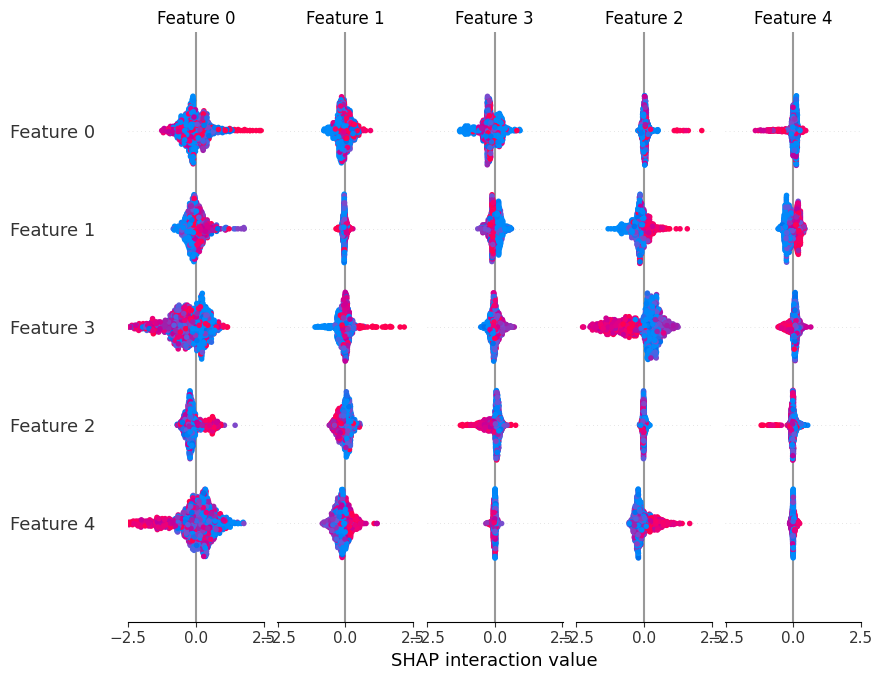

In [30]:
import xgboost as xgb
# Instatiate XGBClassifier
xg_model=XGBClassifier(random_state=42)
xg_model.fit(X_train, y_train)
# Create the SHAP explainer object
explainer = shap.TreeExplainer(xg_model)

# Calculate the SHAP values for the test set
shap_values = explainer.shap_values(X_test)
# Summary
shap.summary_plot(shap_values, X_test)